## Отчет лабораторной работы №1
## Выполнение разведочного анализа больших данных с использованием фреймворка Apache Spark

### Использован датасет: https://www.kaggle.com/datasets/omertarikyilmaz/istabul-traffic-2020-2024
В данной работе будут рассмотрены:
* работа с Dataframe API фреймворка `Apache Spark`;
* разведочный анализ данных.

Разведочный анализ данных будет включать в себя:
* общую информацию о датасете;
* анализ каждой из колонок;
* анализ пропущенных значений, дубликатов и выбросов, их устранение при необходимости;
* рассчет статистических показателей по колонкам;
* построение графиков распределения для колонок;
* корреляцию между признаками всего датасета.

Подключаем необходимые библиотеки.

In [2]:
import os
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.sql.functions import (
    dayofweek, hour, year, month,
    col, lit, sum, mean, when, avg,
    explode, count, desc, floor,
    corr, array_contains, lit, first
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Сформируем объект конфигурации для `Apache Spark`, указав необходимые параметры.

In [3]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    user_name = os.getenv("USER")
    
    conf = SparkConf()
    conf.setAppName("lab 1 Test")
    conf.setMaster("local")
    # conf.set("spark.submit.deployMode", "client")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "1")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "1")
    # conf.set("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    # conf.set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    # conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    # conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    # conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///user/{user_name}/warehouse")
    # conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

Создаём сам объект конфигурации.

In [4]:
conf = create_spark_configuration()

Создаём и выводим на экран сессию `Apache Spark`.

In [5]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

Рассмотрим датасет.

In [6]:
df = spark.read.parquet("data/istanbulTraffic.parquet")

Посмотрим на схему данных и количество строк в датафрейме.

In [6]:
df.printSchema()

root
 |-- DATE_TIME: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- GEOHASH: string (nullable = true)
 |-- MINIMUM_SPEED: string (nullable = true)
 |-- MAXIMUM_SPEED: string (nullable = true)
 |-- AVERAGE_SPEED: string (nullable = true)
 |-- NUMBER_OF_VEHICLES: string (nullable = true)



In [7]:
df.count()

97864888

Исходя из представленной схемы можно увидеть, что все данные заполнены, но воспринимаются как строковые, хотя имеют другой формат.
Переопределим формат, чтобы данные можно было использовать.

In [22]:
def cast_columns(df: DataFrame, 
                 cast_map: dict) -> DataFrame:
    """
    Преобразует несколько столбцов к указанным типам.

    Args:
        df (DataFrame): входной DataFrame
        cast_map (dict): словарь {column_name: new_type}

    Returns:
        DataFrame: новый DataFrame с изменёнными типами столбцов
    """
    for column_name, new_type in cast_map.items():
        df = df.withColumn(column_name, col(column_name).cast(new_type))
    return df

In [23]:
cast_map = {
    "DATE_TIME": "timestamp",
    "LATITUDE": "double",
    "LONGITUDE": "double",
    "GEOHASH": "string",
    "MINIMUM_SPEED": "double",
    "MAXIMUM_SPEED": "double",
    "AVERAGE_SPEED": "double",
    "NUMBER_OF_VEHICLES": "int"
}

df = cast_columns(df, cast_map)

Выведем схему датафрейма.

In [24]:
df.printSchema()

root
 |-- DATE_TIME: timestamp (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- GEOHASH: string (nullable = true)
 |-- MINIMUM_SPEED: double (nullable = true)
 |-- MAXIMUM_SPEED: double (nullable = true)
 |-- AVERAGE_SPEED: double (nullable = true)
 |-- NUMBER_OF_VEHICLES: integer (nullable = true)



Возьмем данные за год и первые два месяца для анализа.

In [25]:
df = df.filter(
    (year("DATE_TIME") == 2020) &
    (month("DATE_TIME").isin([1]))
)
df.count()

1676399

In [14]:
df.show()

+-------------------+----------------+----------------+-------+-------------+-------------+-------------+------------------+
|          DATE_TIME|        LATITUDE|       LONGITUDE|GEOHASH|MINIMUM_SPEED|MAXIMUM_SPEED|AVERAGE_SPEED|NUMBER_OF_VEHICLES|
+-------------------+----------------+----------------+-------+-------------+-------------+-------------+------------------+
|2020-01-28 13:00:00|41.0531616210938|28.8226318359375| sxk3xc|          7.0|         68.0|         34.0|               128|
|2020-01-28 13:00:00|41.0586547851563|29.3060302734375| sxkcdf|         73.0|        109.0|         87.0|                 6|
|2020-01-28 13:00:00|41.0037231445313|29.0423583984375| sxk9kb|          6.0|        120.0|         52.0|               250|
|2020-01-28 13:00:00|41.0256958007813|28.7896728515625| sxk3rh|          6.0|        121.0|         35.0|               174|
|2020-01-28 13:00:00|40.9542846679688|29.3280029296875| sxkbgr|         25.0|        113.0|         63.0|                22|


Теперь можно работать с данными.

#### Анализ столбца `DATE_TIME`

Определим начало и конец взятого интервала.

In [31]:
df_sorted = df.orderBy(col("DATE_TIME"))
first_row = df_sorted.first()
print("Первый элемент:", first_row["DATE_TIME"])
last_row = df_sorted.orderBy(col("DATE_TIME").desc()).first()
print("Последний элемент:", last_row["DATE_TIME"])

Первый элемент: 2020-01-01 00:00:00
Последний элемент: 2020-01-31 23:00:00


Проверим наличие дубликатов в датафрейме.

In [16]:
(
    df
    .groupBy("DATE_TIME")
    .count()
    .where("count > 1")
    .orderBy("count", ascending=False)
    .show()
)

+-------------------+-----+
|          DATE_TIME|count|
+-------------------+-----+
|2020-01-25 12:00:00| 2338|
|2020-01-11 10:00:00| 2336|
|2020-01-28 17:00:00| 2334|
|2020-01-29 10:00:00| 2333|
|2020-01-03 11:00:00| 2331|
|2020-01-04 13:00:00| 2331|
|2020-01-25 15:00:00| 2330|
|2020-01-28 14:00:00| 2330|
|2020-01-23 14:00:00| 2330|
|2020-01-26 14:00:00| 2330|
|2020-01-24 11:00:00| 2330|
|2020-01-21 13:00:00| 2329|
|2020-01-28 13:00:00| 2328|
|2020-01-28 15:00:00| 2328|
|2020-01-11 11:00:00| 2328|
|2020-01-30 13:00:00| 2328|
|2020-01-29 12:00:00| 2327|
|2020-01-30 10:00:00| 2327|
|2020-01-04 12:00:00| 2327|
|2020-01-10 12:00:00| 2326|
+-------------------+-----+
only showing top 20 rows



Видно, что множество данных повторяются. Однако, это объяснимо, поскольку это время замера для различных параметров широты и долготы.
Поэтому проведем анализ количества на группе колонок: сочетание времени, широты и долготы.

In [17]:
(
    df
    .groupBy("DATE_TIME", "LATITUDE", "LONGITUDE")
    .count()
    .where("count > 1")
    .orderBy("count", ascending=False)
    .show()
)

+---------+--------+---------+-----+
|DATE_TIME|LATITUDE|LONGITUDE|count|
+---------+--------+---------+-----+
+---------+--------+---------+-----+



Таким образом, повторяющихся значений, которые необходимо обработать, нет.

Добавим колонки, показывающие час, день недели, месяц, что поможет проиллюстрировать среднюю загруженность за определенный критерий.

In [68]:
df = (df
      .withColumn("day_of_week", dayofweek(col("DATE_TIME")))
      .withColumn("hour", hour(col("DATE_TIME")))
)
df.show()

+-------------------+----------------+----------------+-------+-------------+-------------+-------------+------------------+-----------+----+
|          DATE_TIME|        LATITUDE|       LONGITUDE|GEOHASH|MINIMUM_SPEED|MAXIMUM_SPEED|AVERAGE_SPEED|NUMBER_OF_VEHICLES|day_of_week|hour|
+-------------------+----------------+----------------+-------+-------------+-------------+-------------+------------------+-----------+----+
|2020-01-28 13:00:00|41.0531616210938|28.8226318359375| sxk3xc|          7.0|         68.0|         34.0|               128|          3|  13|
|2020-01-28 13:00:00|41.0586547851563|29.3060302734375| sxkcdf|         73.0|        109.0|         87.0|                 6|          3|  13|
|2020-01-28 13:00:00|41.0037231445313|29.0423583984375| sxk9kb|          6.0|        120.0|         52.0|               250|          3|  13|
|2020-01-28 13:00:00|41.0256958007813|28.7896728515625| sxk3rh|          6.0|        121.0|         35.0|               174|          3|  13|
|2020-

Рассмотрим часы пик - когда больше всего записей о транспортных средствах.

In [19]:
hour_df = (
    df
    .groupBy("hour")
    .count()
    .orderBy("hour")
)

In [20]:
hour_df.show()

+----+-----+
|hour|count|
+----+-----+
|   0|69426|
|   1|68177|
|   2|66564|
|   3|65040|
|   4|65963|
|   5|68525|
|   6|69769|
|   7|69515|
|   8|69354|
|   9|69147|
|  10|71630|
|  11|71254|
|  12|69333|
|  13|71695|
|  14|71697|
|  15|71609|
|  16|71495|
|  17|71404|
|  18|71041|
|  19|71038|
+----+-----+
only showing top 20 rows



Отобразим результаты на графике.

In [21]:
def plot_bar(df: DataFrame, 
             x_col: str, 
             y_col: str, 
             title: str = None, 
             top_n: int = 200000):
    """
    Строит столбчатую диаграмму.
    
    Args:
        df (DataFrame): Spark DataFrame с агрегированными данными
        x_col (str): колонка для оси X
        y_col (str): колонка для оси Y
        title (str, optional): заголовок графика
        top_n (int, optional): если указано, берёт только top_n значений по y_col
    """
    # Ограничиваем DataFrame если задан top_n
    if top_n is not None:
        # сортируем по y_col, берём top_n
        df = df.orderBy(df[y_col].desc()).limit(top_n)
    
    # Собираем данные
    data = df.select(x_col, y_col).collect()
    x_vals = [row[x_col] for row in data]
    y_vals = [row[y_col] for row in data]

    # Строим график
    plt.figure(figsize=(12, 6))
    sns.barplot(x=x_vals, y=y_vals)
    plt.xlabel("Value")
    plt.ylabel("Count")
    if title:
        plt.title(title)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

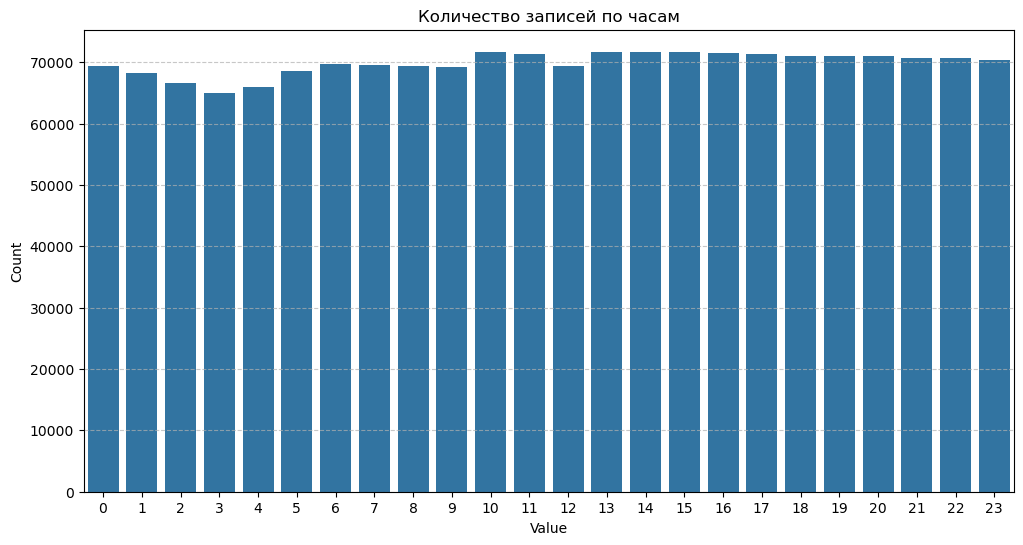

In [22]:
plot_bar(hour_df, x_col="hour", y_col="count", title="Количество записей по часам")

Рассмотрим, в какой день недели больше всего записей о транспортных средствах.

In [23]:
day_df = (
    df
    .groupBy("day_of_week")
    .count()
    .orderBy("day_of_week")
)

In [24]:
day_df.show()

+-----------+------+
|day_of_week| count|
+-----------+------+
|          1|211910|
|          2|217096|
|          3|217576|
|          4|271533|
|          5|271736|
|          6|268137|
|          7|218411|
+-----------+------+



Отобразим результаты на графике.

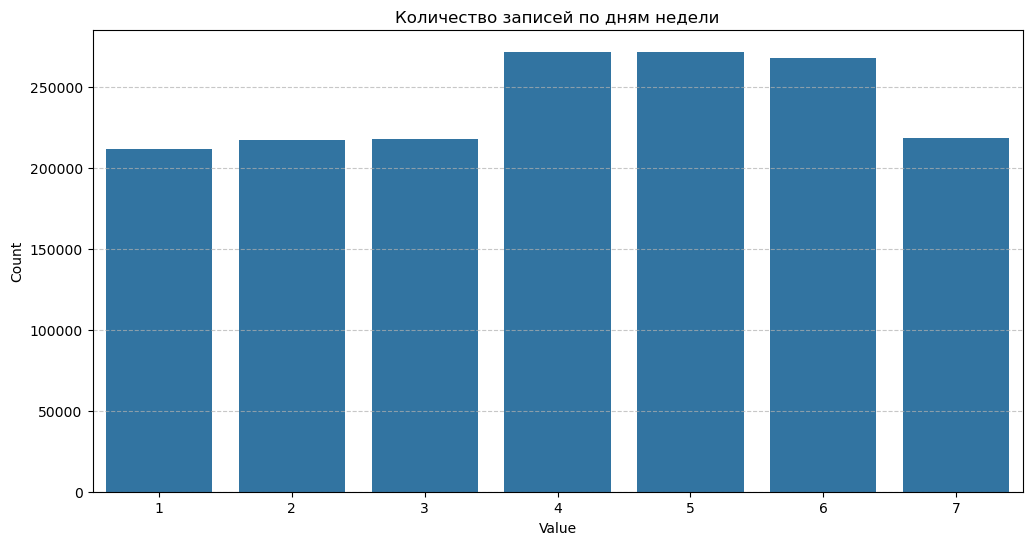

In [25]:
plot_bar(day_df, x_col="day_of_week", y_col="count", title="Количество записей по дням недели")

#### Анализ столбца `LATITUDE` и `LONGITUDE`

Проверим наличие дубликатов в датафрейме.

In [26]:
(
    df
    .groupBy("LATITUDE", "LONGITUDE")
    .count()
    .where("count > 1")
    .orderBy("count", ascending=False)
    .show()
)

+----------------+----------------+-----+
|        LATITUDE|       LONGITUDE|count|
+----------------+----------------+-----+
|41.1630249023438|29.0533447265625|  742|
|40.9927368164063|29.0423583984375|  742|
|41.1080932617188|28.5479736328125|  742|
|41.0311889648438|29.1082763671875|  742|
|41.0202026367188|28.7677001953125|  742|
|41.0092163085938|28.9544677734375|  742|
|41.0202026367188|29.1082763671875|  742|
|41.0806274414063|29.0972900390625|  742|
|40.9817504882813|29.2181396484375|  742|
|41.0531616210938|28.6688232421875|  742|
|40.9872436523438|29.1082763671875|  742|
|40.9982299804688|29.0753173828125|  742|
|40.9817504882813|28.7127685546875|  742|
|41.0202026367188|28.8336181640625|  742|
|41.0476684570313|28.8006591796875|  742|
|41.0366821289063|28.9324951171875|  742|
|40.9982299804688|28.6907958984375|  742|
|41.0092163085938|28.8006591796875|  742|
|41.0092163085938|29.1961669921875|  742|
|41.0092163085938|29.1192626953125|  742|
+----------------+----------------

Однако, проверяя ранее, мы убедились, что они все зафиксированы на разное время. Следовательно, дубликаты допустимы.

Проверим выбросы, построив "ящик", и устраним их при необходимости.

In [9]:
def plot_boxplots(data: DataFrame,
                  columns: list[str],
                  sample_fraction: float = 0.1) -> None:
    """
    Построение boxplot для нескольких столбцов в PySpark DataFrame.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        columns (list of str): Список имен столбцов для построения boxplot.
        sample_fraction (float): Доля данных для семплирования выбросов.
    
    Returns:
        None
    """
    box_data = []

    for column in columns:
        # Вычисление квантилей
        quantiles = data.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
        q1, median, q3 = quantiles

        # Вычисление IQR и границ усов
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Фильтрация выбросов
        filtered_df = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
        outliers_df = data.filter((col(column) < lower_bound) | (col(column) > upper_bound))

        # Вычисление минимального и максимального значений
        min_value = data.agg({column: "min"}).collect()[0][0]
        mean_value = data.agg({column: "mean"}).collect()[0][0]
        std_value = data.agg({column: "std"}).collect()[0][0]
        max_value = data.agg({column: "max"}).collect()[0][0]

        # Ограничение усов минимальным и максимальным значениями
        lower_bound = max(lower_bound, min_value)
        upper_bound = min(upper_bound, max_value)

        # Семплирование выбросов
        outliers = []
        if not outliers_df.isEmpty():
            sampled_outliers_df = outliers_df.sample(sample_fraction)
            outliers = (
                sampled_outliers_df
                .select(column)
                .limit(1000)
                .collect()
            )
            outliers = [row[column] for row in outliers]
            
            # Добавление минимального и максимального значений, если они 
            # относятся к выбросам и не присутствуют в семпле
            if min_value < lower_bound and min_value not in outliers:
                outliers.append(min_value)
            if max_value > upper_bound and max_value not in outliers:
                outliers.append(max_value)

        # Подготовка данных для axes.bxp
        box_data.append({
            'whislo': lower_bound,  # Нижняя граница усов
            'q1': q1,               # Первый квартиль
            'med': median,          # Медиана
            'q3': q3,               # Третий квартиль
            'whishi': upper_bound,  # Верхняя граница усов
            'fliers': outliers      # Выбросы
        })
        
    # Вывод статистических характеристик
    print(f"Минимальное значение:          {min_value:.2f}")
    print(f"Среднее значение:              {mean_value:.2f}")
    print(f"Среднеквадратичное отклонение: {std_value:.2f}")
    print(f"Первый квартиль:               {q1:.2f}")
    print(f"Медиана:                       {median:.2f}")
    print(f"Третий квартиль:               {q3:.2f}")
    print(f"Максимальное значение:         {max_value:.2f}")

    # Построение boxplot
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.bxp(box_data, 
           vert=False, 
           positions=range(1, len(columns) + 1), widths=0.5)
    ax.set_yticks(range(1, len(columns) + 1))
    ax.set_yticklabels(columns)
    ax.set_xlabel('Value')
    ax.set_title('Boxplots')
    ax.grid(True)
    plt.show()

Минимальное значение:          40.75
Среднее значение:              41.06
Среднеквадратичное отклонение: 0.10
Первый квартиль:               41.00
Медиана:                       41.06
Третий квартиль:               41.13
Максимальное значение:         41.65


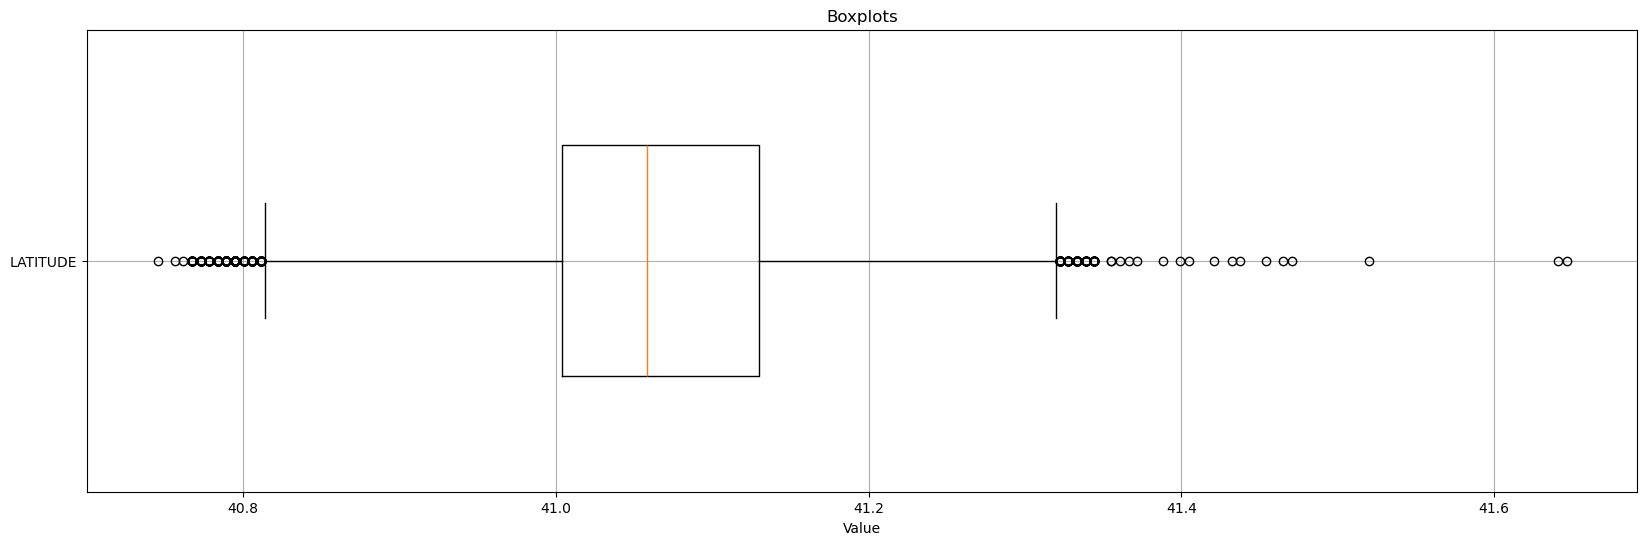

Минимальное значение:          27.97
Среднее значение:              28.88
Среднеквадратичное отклонение: 0.35
Первый квартиль:               28.70
Медиана:                       28.93
Третий квартиль:               29.14
Максимальное значение:         29.89


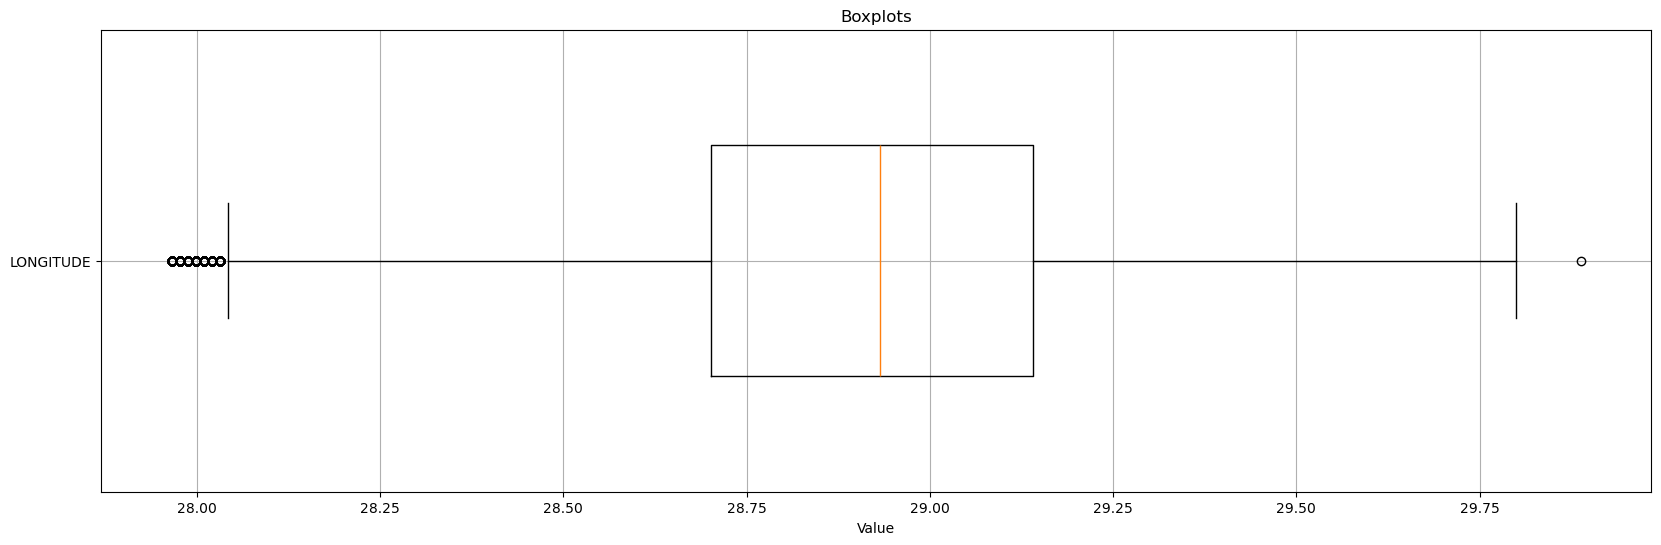

In [10]:
plot_boxplots(data=df, columns=["LATITUDE"])
plot_boxplots(data=df, columns=["LONGITUDE"])

Заметны выбросы. Для более тщательного исследования построим график визуального распределения признака.

In [26]:
def plot_quant_distribution(data: DataFrame,
                            column: str,
                            num_bins: int = 200) -> None:
    """
    Построение гистограммы для количественной переменной с 
    использованием PySpark и Seaborn.

    Args:
        data (DataFrame): DataFrame с данными.
        column_name (str): Название колонки с количественной переменной.
        num_bins (int): Количество бинов для гистограммы.

    Returns:
        None
    """
    # Находим минимальное и максимальное значения колонки
    min_value = data.agg({column: "min"}).collect()[0][0]
    max_value = data.agg({column: "max"}).collect()[0][0]

    # Размер бина
    bin_size = (max_value - min_value) / num_bins

    # Добавляем колонку с номером бина
    data = data.withColumn(
        "bin", 
        floor((col(column) - min_value) / bin_size)
    )

    # Группируем по номеру бина и считаем количество строк в каждом бине
    bin_counts = data.groupBy("bin").count()

    # Преобразуем результат в Pandas DataFrame для построения гистограммы
    bin_counts_pd = bin_counts.limit(1000).toPandas()
    
    # Создаем массив границ бинов
    bin_edges = [min_value + i * bin_size for i in range(num_bins + 2)]
    
    # Преобразуем номера бинов в центры бинов
    bin_centers = [
        (bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins + 1)
    ]
    
    # Добавляем центры бинов в Pandas DataFrame
    bin_counts_pd['bin_center'] = bin_counts_pd['bin'].apply(
        lambda x: bin_centers[int(x)]
    )
    
    # Построение гистограммы с использованием Seaborn
    plt.figure(figsize=(20, 6))
    sns.histplot(data=bin_counts_pd, x="bin_center", 
                 weights="count", kde=True, bins=num_bins + 1)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.title(f"Распределение количественного признака \"{column}\"")
    plt.locator_params(axis='x', nbins=30)
    plt.grid(True)
    plt.show()

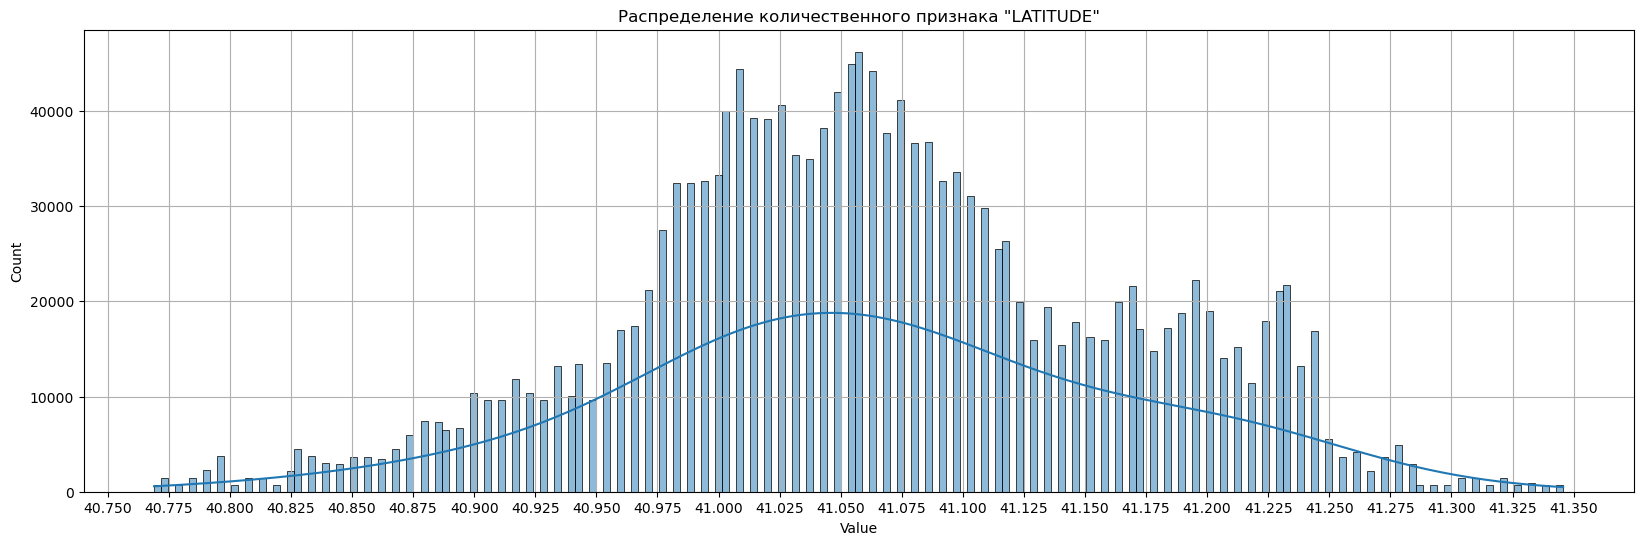

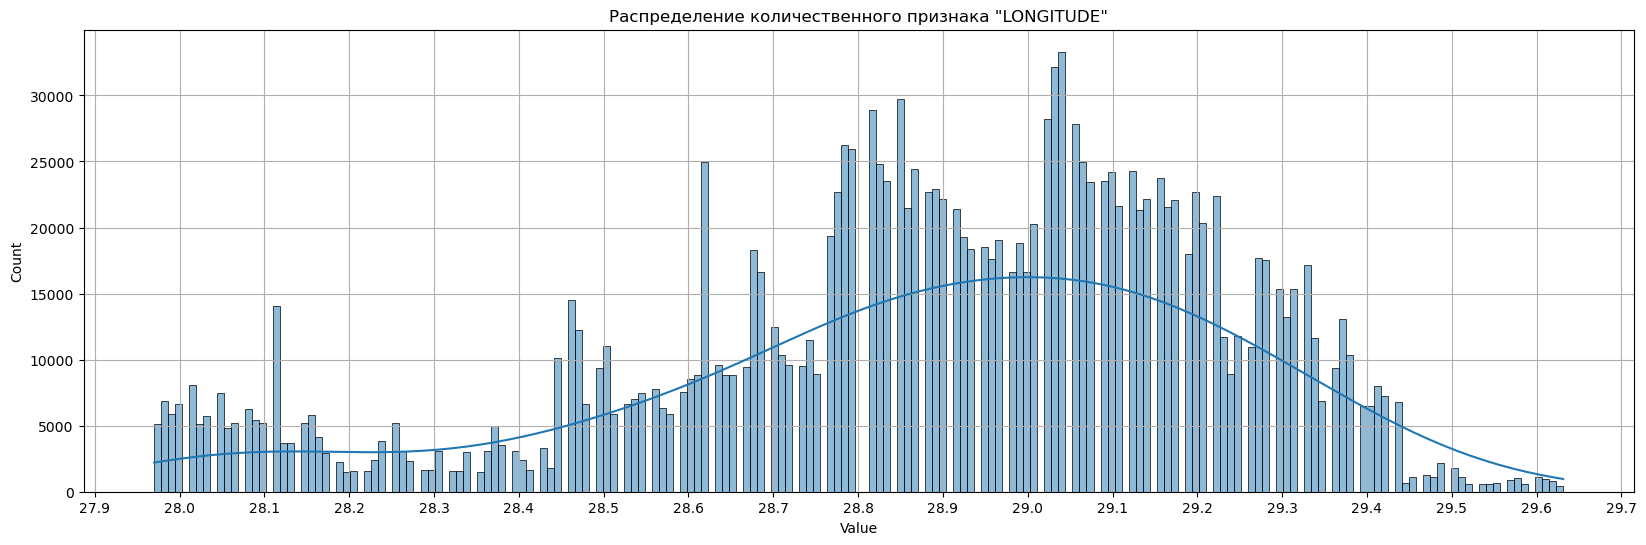

In [27]:
plot_quant_distribution(data=df, column="LATITUDE")
plot_quant_distribution(data=df, column="LONGITUDE")

Видно, что данные содержатся в определенных границах. Чистить не имеет смысла.

#### Анализ столбца `GEOHASH`

Проверим наличие дубликатов в столбце.

In [34]:
(
    df
    .groupBy("GEOHASH")
    .count()
    .where("count > 1")
    .orderBy("count", ascending=False)
    .show()
)

+-------+-----+
|GEOHASH|count|
+-------+-----+
| sxk9dk|  742|
| sxk9g0|  742|
| sxkc1d|  742|
| sxk9m3|  742|
| sxk9qw|  742|
| sxk3s9|  742|
| sxk9f2|  742|
| sxk9g6|  742|
| sxk3eu|  742|
| sxk3cg|  742|
| sxk9nw|  742|
| sxk9wd|  742|
| sxk8zc|  742|
| sxk9mw|  742|
| sxk3z0|  742|
| sxk979|  742|
| sxk9n4|  742|
| sxk9es|  742|
| sxk3rf|  742|
| sxk9uq|  742|
+-------+-----+
only showing top 20 rows



Однако для данного столбца это нормально. Убедимся.

In [35]:
(
    df
    .groupBy("DATE_TIME", "LATITUDE", "LONGITUDE", "GEOHASH")
    .count()
    .where("count > 1")
    .orderBy("count", ascending=False)
    .show()
)

+---------+--------+---------+-------+-----+
|DATE_TIME|LATITUDE|LONGITUDE|GEOHASH|count|
+---------+--------+---------+-------+-----+
+---------+--------+---------+-------+-----+



Посмотрим все возможные значения на графике

In [36]:
def plot_cat_distribution(data: DataFrame,
                          column_name: str,
                          top_n: int = 20) -> None:
    """
    Построение распределения категориального признака.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для группировки.
        top_n (int): Количество топ-значений для отображения.
    
    Returns:
        None
    """
    # Группировка данных по столбцу и подсчет количества
    categories = (
        data
        .groupBy(column_name)
        .count()
        .orderBy("count", ascending=False)
    )
    
    print(f"Количество категорий признака {column_name}: {categories.count()}")

    categories = (
        categories
        .limit(top_n)
        .toPandas()
    )
    
    # Визуализация с использованием Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column_name, y="count", data=categories)
    plt.title(f"Barplot of \"{column_name}\" counts")
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

Количество категорий признака GEOHASH: 2400


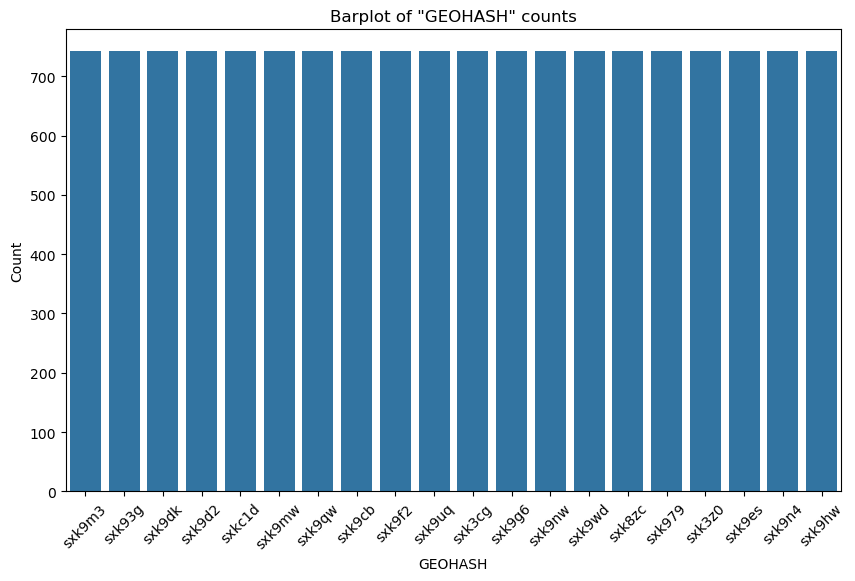

In [37]:
plot_cat_distribution(data=df, column_name="GEOHASH")

На графике отражено всего несколько из общего количества. Однако видно, что данные распределены равномерно - количество одинаково.

#### Анализ столбца `MINIMUM_SPEED`

Дубликаты в данном случае могут быть, и это нормально. Поэтому сразу построим "ящик".

Минимальное значение:          0.00
Среднее значение:              25.73
Среднеквадратичное отклонение: 23.44
Первый квартиль:               6.00
Медиана:                       13.00
Третий квартиль:               45.00
Максимальное значение:         196.00


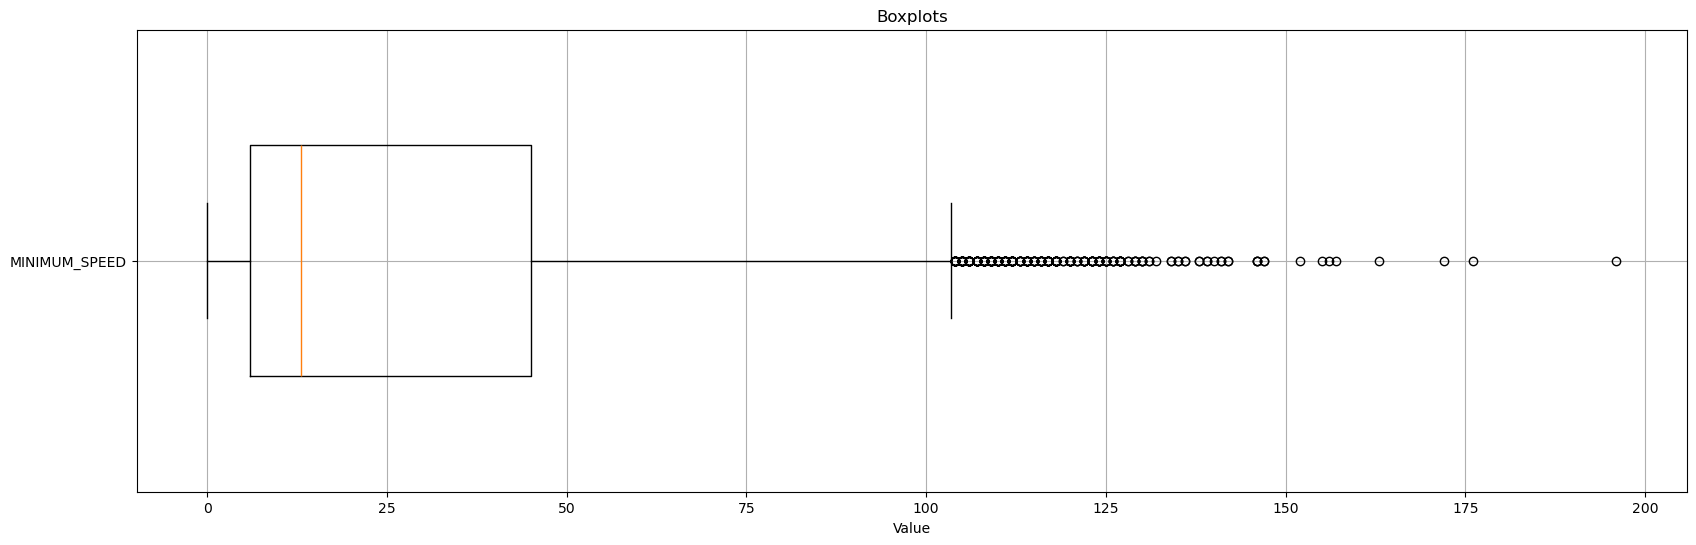

In [39]:
plot_boxplots(data=df, columns=["MINIMUM_SPEED"])

Видно множество выбросов. Рассмотрим подробнее.

In [46]:
df_new = df.withColumn(
    "MINIMUM_SPEED",
    when(col("MINIMUM_SPEED") > 100.0, 500.0)
        .otherwise(col("MINIMUM_SPEED"))
)

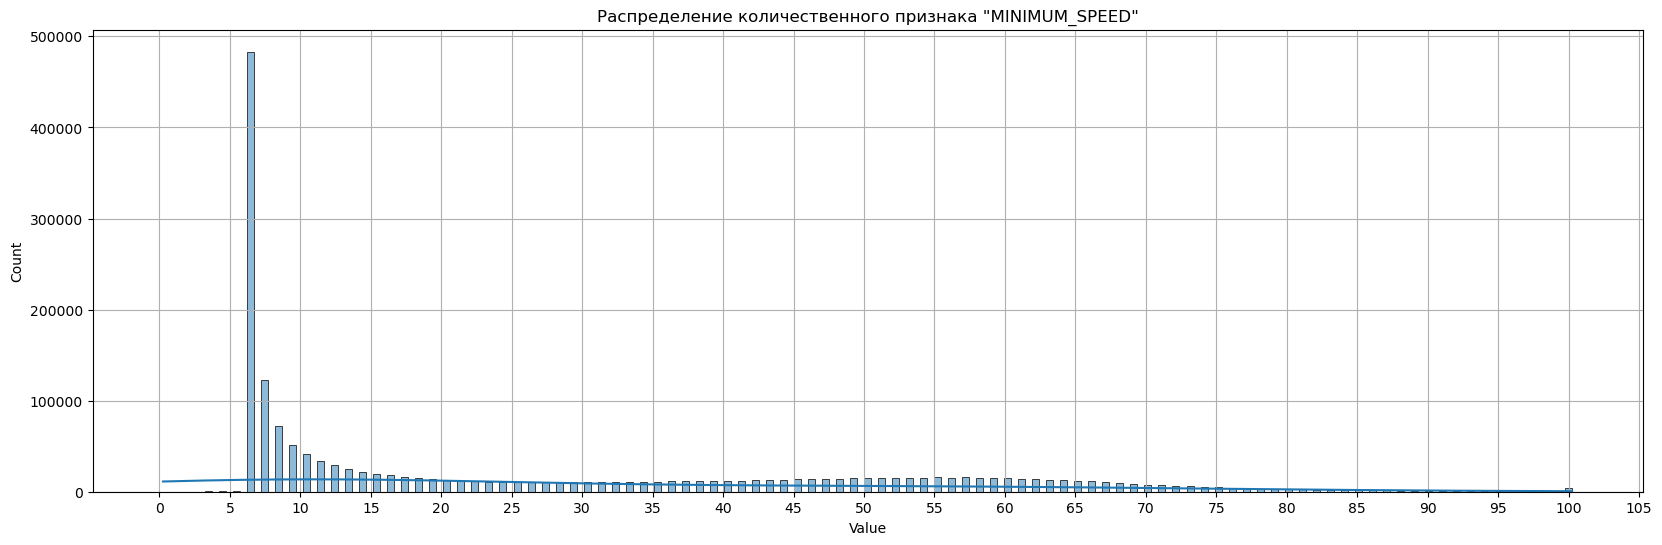

In [45]:
plot_quant_distribution(data=df_new, column="MINIMUM_SPEED")

Закрепим такое ограничение.

In [48]:
df = df_new

#### Анализ столбца `MAXIMUM_SPEED`

Анализ данного столбца аналогичен предыдущему.
Дубликаты в данном случае могут быть, и это нормально. Поэтому сразу построим "ящик".

Минимальное значение:          6.00
Среднее значение:              95.89
Среднеквадратичное отклонение: 33.05
Первый квартиль:               69.00
Медиана:                       96.00
Третий квартиль:               121.00
Максимальное значение:         249.00


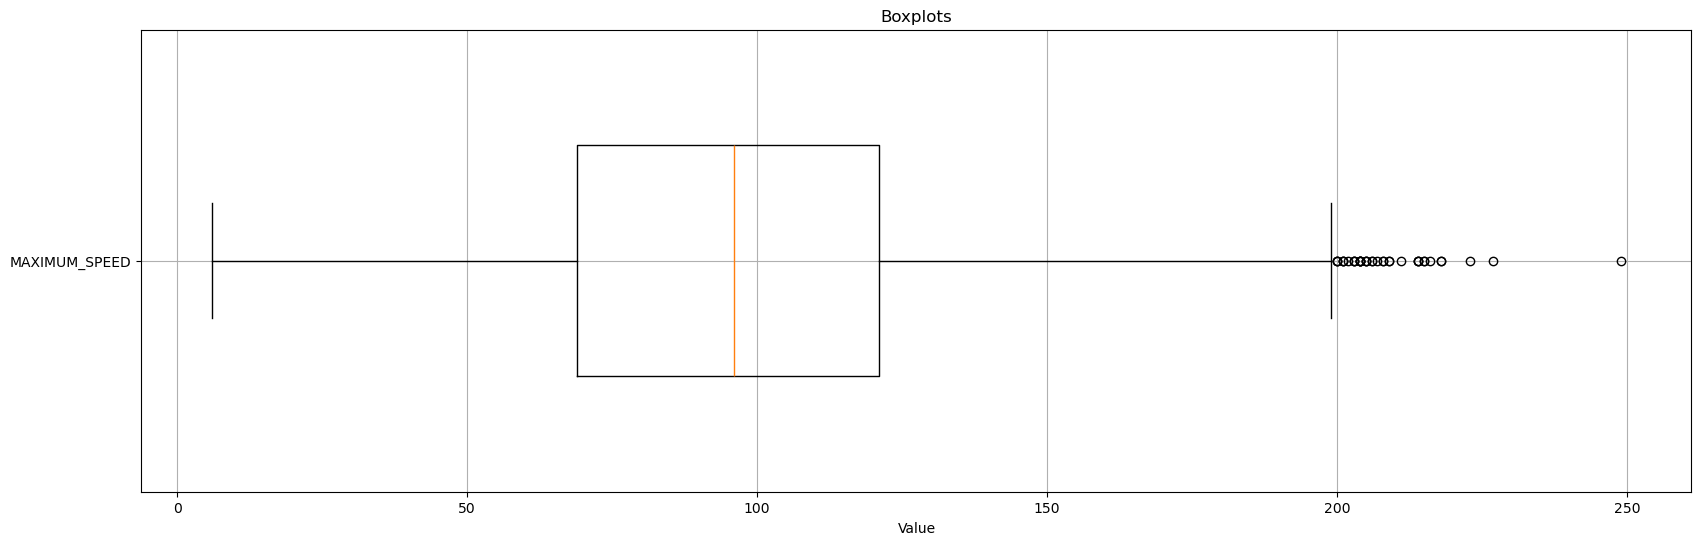

In [49]:
plot_boxplots(data=df, columns=["MAXIMUM_SPEED"])

Видны выбросы. Рассмотрим подробнее.

In [50]:
df_new = df.withColumn(
    "MAXIMUM_SPEED",
    when(col("MAXIMUM_SPEED") > 200.0, 200.0)
        .otherwise(col("MAXIMUM_SPEED"))
)

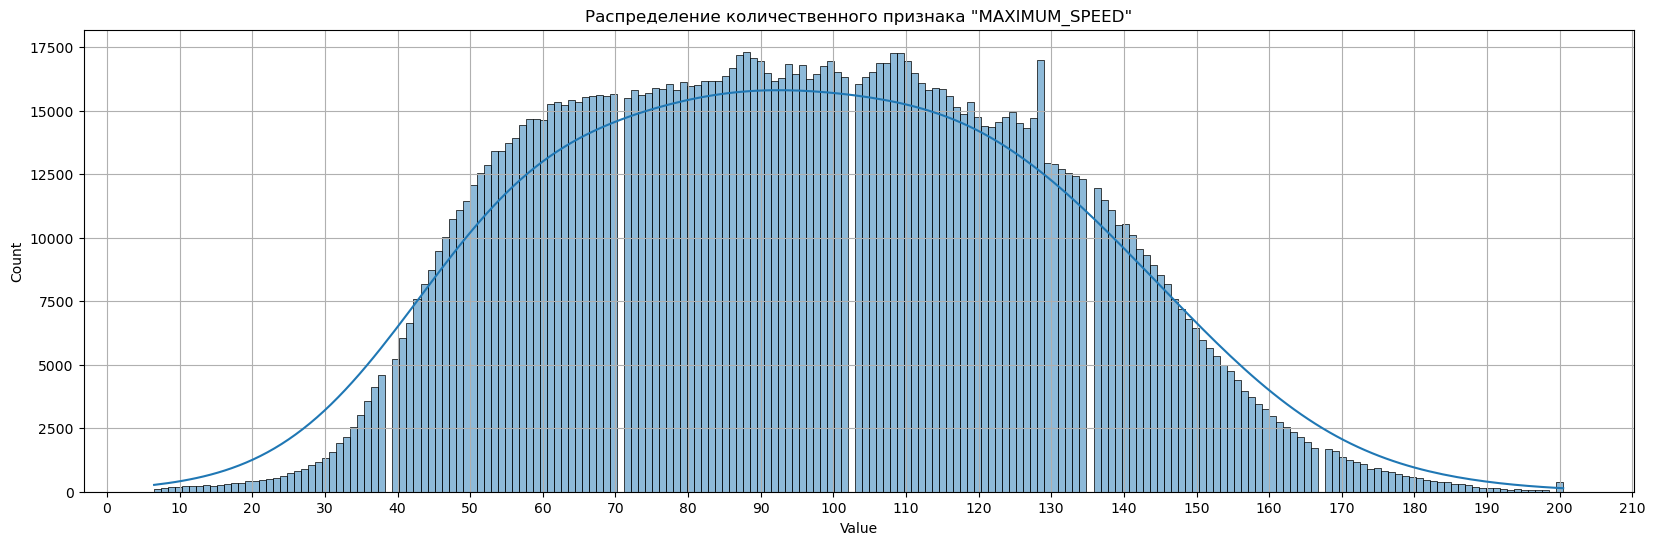

In [51]:
plot_quant_distribution(data=df_new, column="MAXIMUM_SPEED")

Закрепим такое ограничение.

In [52]:
df = df_new

#### Анализ столбца `AVERAGE_SPEED`

Дубликаты в данном случае могут быть, и это нормально. Поэтому сразу построим "ящик".

Минимальное значение:          6.00
Среднее значение:              55.65
Среднеквадратичное отклонение: 24.08
Первый квартиль:               34.00
Медиана:                       56.00
Третий квартиль:               78.00
Максимальное значение:         196.00


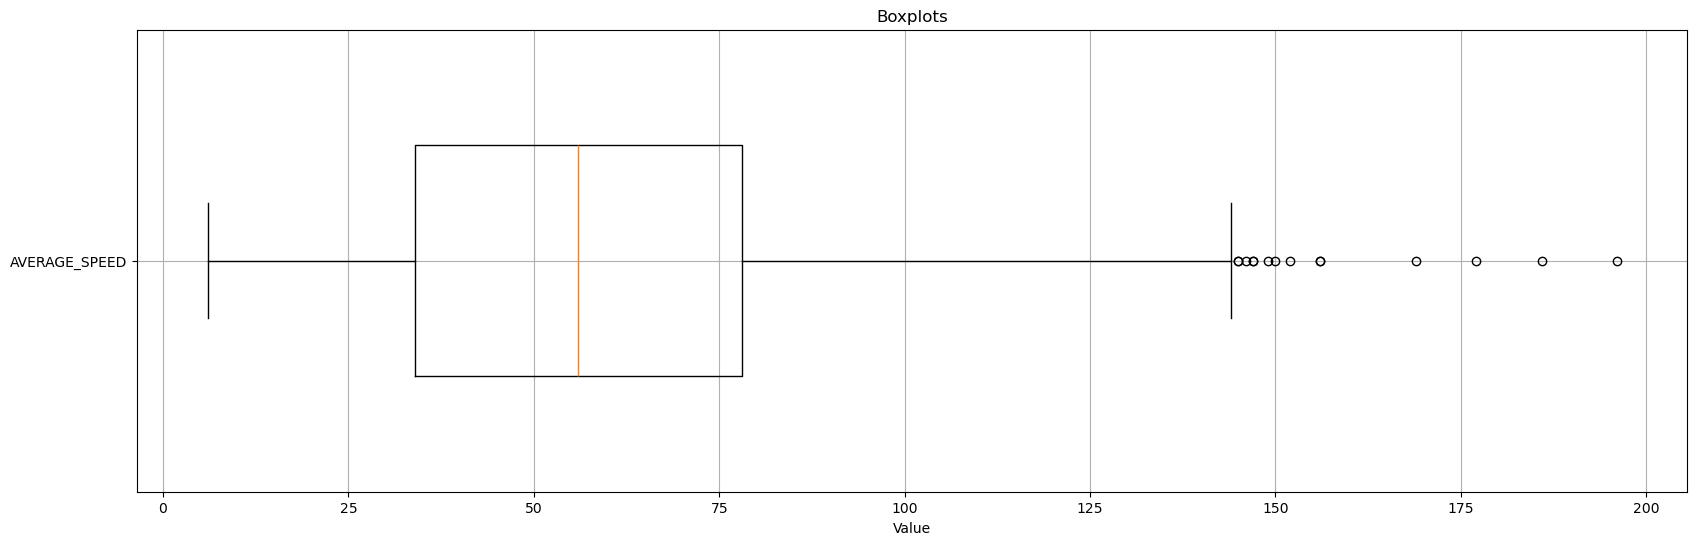

In [53]:
plot_boxplots(data=df, columns=["AVERAGE_SPEED"])

Видны выбросы. Рассмотрим подробнее.

In [60]:
df_new = df.withColumn(
    "AVERAGE_SPEED",
    when(col("AVERAGE_SPEED") > 140.0, 140.0)
        .otherwise(col("AVERAGE_SPEED"))
)

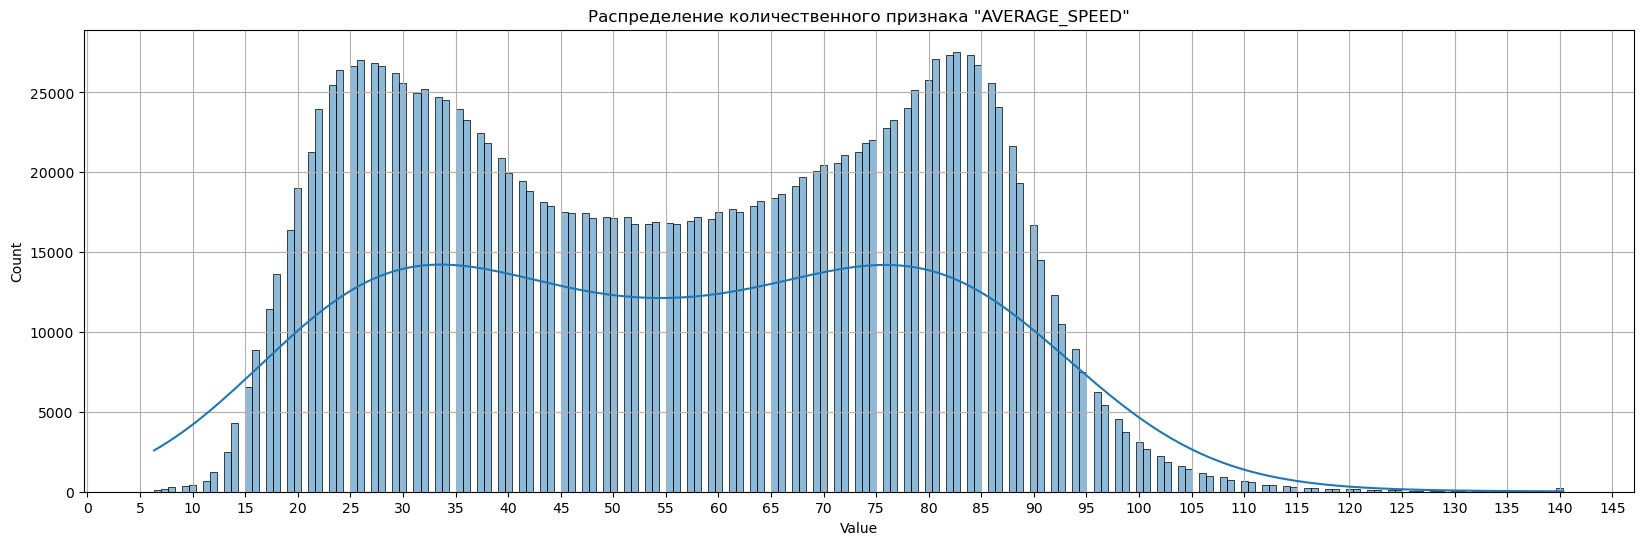

In [61]:
plot_quant_distribution(data=df_new, column="AVERAGE_SPEED")

Закрепим такое ограничение.

In [62]:
df = df_new

Рассмотрим распределение средней скорости по часам.

In [84]:
def plot_avg_by_hour(df: DataFrame, 
                           speed_col: str,
                           col_arg: str,
                           title: str = "Распределение средней скорости в зависимости от часа"):
    """
    Строит график распределения средней скорости в зависимости от col_arg.

    Parameters:
        df: PySpark DataFrame
        speed_col: имя колонки со скоростью
        col_arg: имя колонки, по которой агрегируем
        title: заголовок графика (по умолчанию общий)
    """

    df_arg = df.groupBy(col_arg).agg(
        avg(col(speed_col)).alias("avg_value")
    ).orderBy(col_arg)

    # Собираем данные
    data = df_arg.collect()
    x_vals = [row[col_arg] for row in data]
    y_vals = [row['avg_value'] for row in data]

    # Строим график
    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, y_vals, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel(col_arg)
    plt.ylabel(f"Среднее {speed_col}")
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.show()


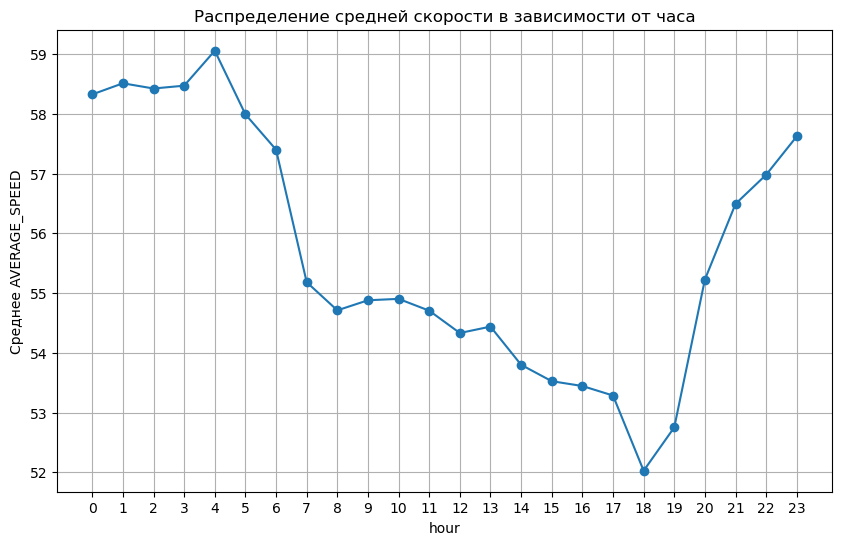

In [85]:
plot_avg_by_hour(df, "AVERAGE_SPEED", "hour")

#### Анализ столбца `NUMBER_OF_VEHICLES`

Дубликаты в данном случае могут быть, и это нормально. Поэтому сразу построим "ящик".

Минимальное значение:          1.00
Среднее значение:              79.53
Среднеквадратичное отклонение: 104.87
Первый квартиль:               14.00
Медиана:                       41.00
Третий квартиль:               104.00
Максимальное значение:         1267.00


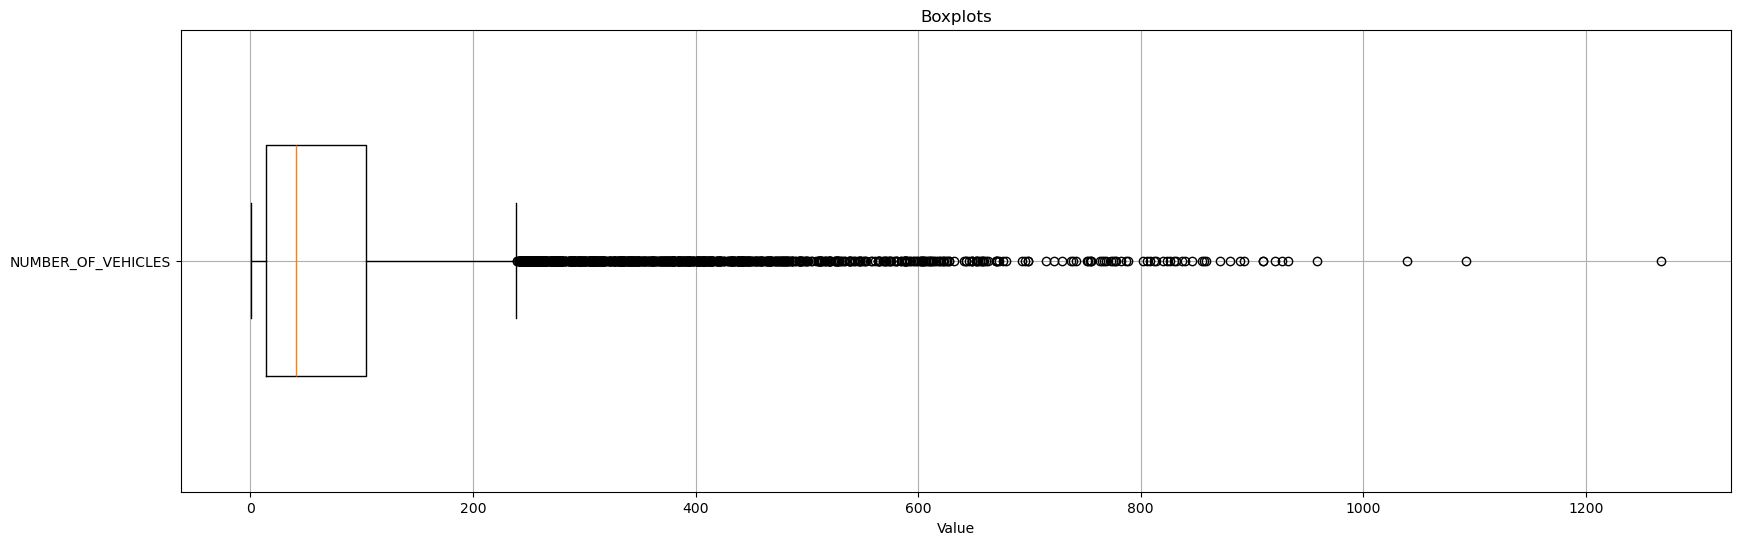

In [88]:
plot_boxplots(data=df, columns=["NUMBER_OF_VEHICLES"])

Видны множественные выбросы. Рассмотрим подробнее.

In [90]:
df_new = df.withColumn(
    "NUMBER_OF_VEHICLES",
    when(col("NUMBER_OF_VEHICLES") > 250.0, 250.0)
        .otherwise(col("NUMBER_OF_VEHICLES"))
)

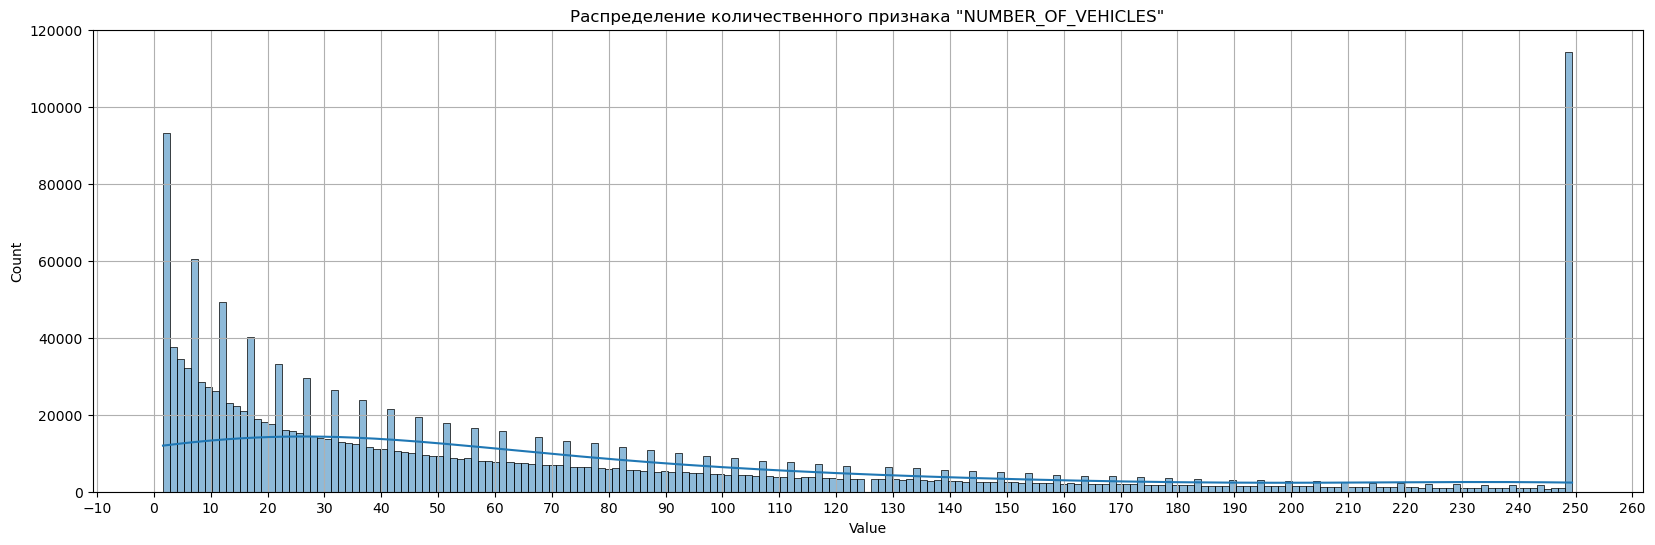

In [91]:
plot_quant_distribution(data=df_new, column="NUMBER_OF_VEHICLES")

Закрепим такое ограничение.

In [93]:
df = df_new

Рассмотрим соотношение средней скорости и количества машин, которые предоставили свои скоростные данные.

In [ ]:
def plot_speed_vs_traffic(df, speed_col="AVERAGE_SPEED", vehicles_col="NUMBER_OF_VEHICLES", limit_size=100000):
    """
    Строит scatter plot: скорость vs количество машин.
    Если данных слишком много, берём случайную подвыборку.
    """
    # Выборка
    df_sample = df.select(vehicles_col, speed_col).limit(limit_size)
    
    data = df_sample.select(vehicles_col, speed_col).collect()
    x_vals = [row[vehicles_col] for row in data]
    y_vals = [row[speed_col] for row in data]

    plt.figure(figsize=(10, 6))
    plt.scatter(x_vals, y_vals, alpha=0.4, s=1)
    plt.title("Соотношение скорость / трафик (выборка)")
    plt.xlabel("Количество машин")
    plt.ylabel("Средняя скорость")
    plt.grid(True)
    plt.show()


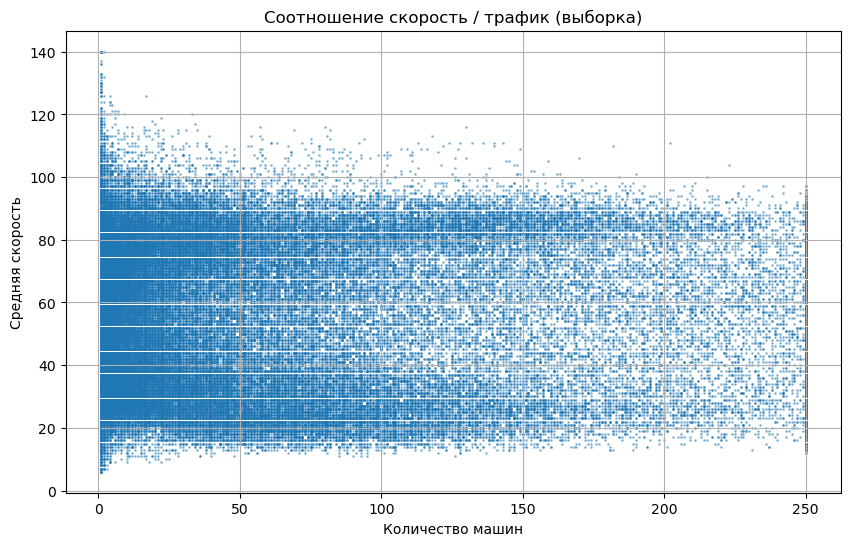

+---------------------------------------+
|corr(AVERAGE_SPEED, NUMBER_OF_VEHICLES)|
+---------------------------------------+
|                   -0.06147342125338246|
+---------------------------------------+



In [107]:
plot_speed_vs_traffic(df)
df.select(corr("AVERAGE_SPEED", "NUMBER_OF_VEHICLES")).show()

Из значений корреляции и графика следует, что в данных были явно смешаны как скоростные магистрали, так и городские улицы. 
Кроме того, данные из колонки средней скорости уже могли быть усреднены.

#### Корреляционная матрица

Учитываем только количественные признаки.

In [113]:
def compute_and_visualize_correlation_matrix(data: DataFrame, 
                                             columns: list[str]) -> None:
    """
    Вычисляет и визуализирует корреляционную матрицу для указанных 
    колонок в DataFrame PySpark.

    Args:
        df (DataFrame): DataFrame PySpark.
        columns (list[str]): Список колонок для вычисления корреляции.

    Returns:
        None
    """
    # Берём только первые строки
    df_sample = data.select(columns).limit(100)
    
    # Вычисление корреляционной матрицы
    corr_matrix = {}
    for col1 in columns:
        corr_matrix[col1] = {}
        for col2 in columns:
            corr_value = df_sample.select(corr(col1, col2)).collect()[0][0]
            corr_matrix[col1][col2] = corr_value

    # Преобразование в pandas DataFrame для визуализации
    corr_matrix_pd = pd.DataFrame(corr_matrix)

    # Визуализация
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix_pd, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

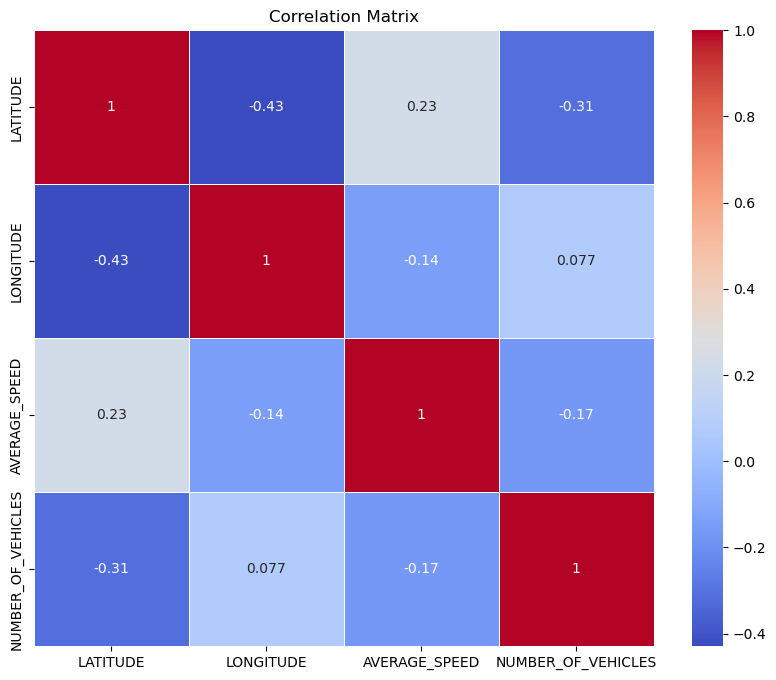

In [115]:
compute_and_visualize_correlation_matrix(
    data=df, columns=[
        "LATITUDE", "LONGITUDE", "AVERAGE_SPEED", "NUMBER_OF_VEHICLES"
    ]
)

Останавливаем сессию.

In [116]:
spark.stop()